In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import ast
from scipy import stats

## Open Food Data - Exploratory Data Analysis, translating additives to warnings and sugar intake in the UK


# Abstract
The purpose of this study is in first place to thoroughly assess the data in the Open Food Data set. I believe that nuances of the dataset like top contributors are not covered deep enough in the available Kaggle kernels.

In second place, two other topics of general interest were addresses - sugar intake and food additives. I used statistics of household food purchases from The UK Department for Environment, Food & Rural Affairs (UK DEFR) and the Open Food Data to assess real intake of sugar from 3 categories of food from 1992 to 2017. Then the results were compared to the World Health Organization sugar intake recommendations.

I scraped the internet to build a dataset of additives and current label warnings for them. I felt like that would be a natural addition to the Open Food Dataset. The added information revealed that significant portion of the food in the dataset requires a warning on the label clear enough for buyers. What is more, substances that are banned or phased-out in the EU were still to be found on some of the food.


## **1. Know your data sources**

Before doing any actual exploration of the data, I would like to understand more on how the Open Food Data is collected. The purpose of this first step is to understand biases that might be introduced by the methods of data collection.

[Open Food Data](https://world.openfoodfacts.org/who-we-are) is an open-source, *"collaborative project with contributors from all around the world"*. The project was started by Stéphane Gigandet, creator of food-related projects and blogs. Most of the initial contributors were French (see the [Who-we-are page](https://world.openfoodfacts.org/who-we-are)).

Data is entered by volunteer contributors or food product manufacturers via the Open Food Data website or mobile apps. While there is no rigorous verification of the data quality at entry, Open Food Data has automatic checks to highlight outlier data. In addition, the dataset has been added to Kaggle Datasets for 3 years and is part of Google Summer of Code. Thus, the data is subject to attention and scrutiny by the Data Science community.

Still, the data collecion method introduces biases. For example, I would need to be cautious how I use the dataset for questions on eating habits per economic class, as certain classes (e.g. very poor and very rich) are very unlikely to be a volunteer for this cause. Similarly, many countries without widespread internet usage are unlikely to be well-represented in the data. 

As a summary, Open Food Data is a French initiative that has grown popular worldiwide. Data is entered by volunteers or food product manufacturers with access to internet, willingness, state-of-mind and time to contribute to a good cause.

## **2. Know your data**

First, I will examine what data does Open Food Data provide. I need to note that I used Kaggle Kernels to load and explore the full dataset first. It proved to be faster than loading it locally or loading the data in pieces.

In [3]:
food_data = pd.read_table('en.openfoodfacts.org.products.tsv', low_memory=False)

In [4]:
print("The Open Food Data dataframe has "+ str(food_data.shape[0]) + ' rows and ' + str(food_data.shape[1]) + ' columns.')

The Open Food Data dataframe has 356027 rows and 163 columns.


In [5]:
food_data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Splitting the columns in two, as info() hides column attributes for 100+ column datasets without enlarging the notebook window
food_data.iloc[:,0:100].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 100 columns):
code                                          356001 non-null object
url                                           356001 non-null object
creator                                       356024 non-null object
created_t                                     356024 non-null object
created_datetime                              356017 non-null object
last_modified_t                               356027 non-null object
last_modified_datetime                        356027 non-null object
product_name                                  338515 non-null object
generic_name                                  57714 non-null object
quantity                                      119285 non-null object
packaging                                     89959 non-null object
packaging_tags                                89959 non-null object
brands                                        326977 non-null o

In [7]:
food_data.iloc[:,100:163].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 63 columns):
cholesterol_100g                        144170 non-null float64
carbohydrates_100g                      279220 non-null float64
sugars_100g                             279186 non-null float64
-sucrose_100g                           85 non-null float64
-glucose_100g                           32 non-null float64
-fructose_100g                          44 non-null float64
-lactose_100g                           278 non-null float64
-maltose_100g                           6 non-null float64
-maltodextrins_100g                     11 non-null float64
starch_100g                             291 non-null float64
polyols_100g                            451 non-null float64
fiber_100g                              220683 non-null float64
proteins_100g                           294161 non-null float64
casein_100g                             29 non-null float64
serum-proteins_100g        

The dataset has more than 356000 entries in 163 columns. The size of the data does not allow us to simply look at the results of the head() method and get a good feeling of the data. It will require closer expection of the columns of interest to understand the information contained.

Out of the 163 columns, many contain information for only a very small portion of the dataset and only a handfull have no NaN entries. At first, I will focus on columns containing at least 10% data (not a NaN):

In [8]:
columns_with_data = []
for column in food_data.columns:
    if food_data[column].notnull().sum()> food_data.shape[0]*0.1:
        columns_with_data.append(column)

In [9]:
food_data_main_columns = food_data[columns_with_data]
food_data_main_columns.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,3.6,3.57,0.00000,0.000,0.0,0.0214,0.000,0.00129,14.0,14.0
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,7.1,17.86,0.63500,0.250,0.0,0.0000,0.071,0.00129,0.0,0.0
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,7.1,17.86,1.22428,0.482,NaN,NaN,0.143,0.00514,12.0,12.0
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As a next step, I will test the initial thoughts on contributors and countries. Were the main contributors volunteers and food manufactorers? Is French data dominent in the dataset?

In [10]:
food_data_main_columns.groupby('creator').size().sort_values(ascending = False).head(10)

creator
usda-ndb-import               169868
openfoodfacts-contributors     45805
kiliweb                        36379
date-limite-app                12679
openfood-ch-import             11469
tacite                          7918
sebleouf                        6444
tacinte                         4809
javichu                         2768
stephane                        2760
dtype: int64

More than 3/4 of the dataset is added by 5 creators:
- usda-ndb-import               169868 entries
- openfoodfacts-contributors     45805 entries
- kiliweb                        36379 entries
- date-limite-app                12679 entries
- openfood-ch-import             11469 entries

USDA NDB, the by far top creator with almost 50% of all entries, stands for United States Department of Agriculture Nutrition DataBase. Kiliweb (most probably) is a French hosting company. Date Limite is a mobile app that lists products in refridgerator and sends notification to its user to avoid food waste. Openfood CH is a similar to Open Food Data, Swiss food-data-based initiative.

Was the data from the top 5 creators loaded in a single shot or uploaded over time?

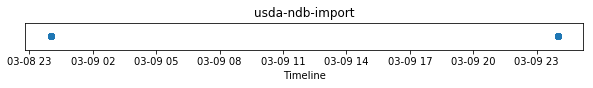

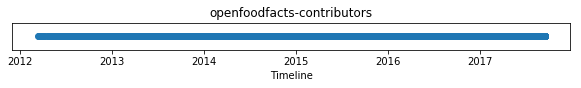

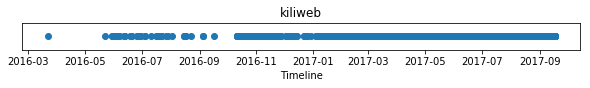

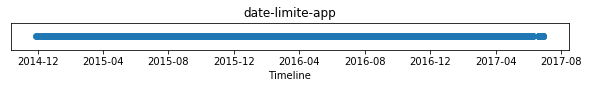

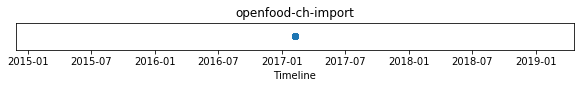

In [11]:
top_creators = ['usda-ndb-import', 'openfoodfacts-contributors', 'kiliweb', 'date-limite-app', 'openfood-ch-import']

for creator in top_creators:
    time_created = pd.to_datetime(food_data_main_columns[food_data_main_columns.creator == creator].created_datetime.str.slice(0,10), format = "%Y/%m/%d")
    plt.figure(figsize=(10, 0.5), facecolor='w', edgecolor='k')
    plt.title(creator)
    plt.yticks([])
    plt.xlabel("Timeline")
    plt.plot_date(time_created, np.full((len(time_created),1), 1))
    
plt.show()

The USDA and Openfood CH entries were loaded within 24h (most probably - a data import, as their title suggests), while the other 3 top contributors have been consistently providing details for a longer period of time. <br />
Using data from other big datasets has the obvious advantage of getting more data in the same place, but also introduces additional bias to the combined one. One has to know how information was collected for USDA and Openfood CH in first place to fully understand possible biases. Especially considering that USDA and Openfood CH comprise more than half of all data entries, I believe that fact should be highlighted, with possible addition information on those 2 sources provided with the dataset.

Next, I would like to understand the contents of the product and brand-related categories. 

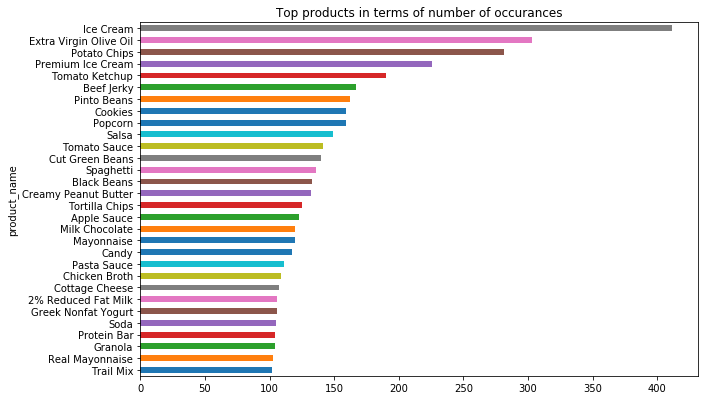

In [12]:
top_products = food_data_main_columns.groupby('product_name').size().sort_values(ascending = False) 
top30_products = food_data_main_columns.groupby('product_name').size().sort_values(ascending = False).head(30)
top30_products.sort_values(ascending = True).plot(kind='barh', figsize = (10,6.5), title = "Top products in terms of number of occurances")
plt.show()

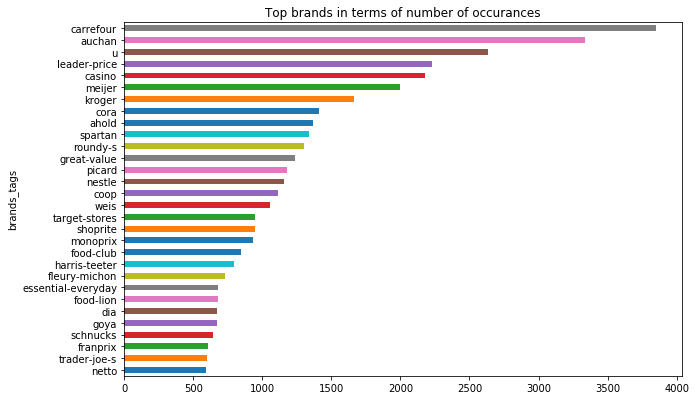

In [13]:
top_brands = food_data_main_columns.groupby('brands_tags').size().sort_values(ascending = False)
top30_brands = food_data_main_columns.groupby('brands_tags').size().sort_values(ascending = False).head(30)
top30_brands.sort_values(ascending = True).plot(kind='barh', figsize = (10,6.5), title = "Top brands in terms of number of occurances")
plt.show()

There are few surprises in the group of top products (after all, ice cream = happiness:). Most of the products are globally popular with generic names. However, missing from the top products are not labeled, but vital products - bread, potatoes, rice. Perhaps contributors had not considered or were not able to add those more frequently, due to lack of labeling or information. 

Interestingly, Top 10 consists entirely of retailers. Nestle is the first food processing giant (ranked 14), but with that exception, retailers dominate the top brands. 

Are retailer's private labels really dominating to that exend or perhaps it is a data inconsistency - marking the store of purchase as a brand, rather than the brand itself?
In order to test if the brand tags were marked correctly, I will check the branding for two of the most popular brands in the world - Coca-Cola and Pepsi.

In [14]:
coca_cola = food_data_main_columns[(food_data_main_columns.product_name.str.lower() == "coca cola")|(food_data_main_columns.product_name.str.lower() == "coca-cola")]
pepsi = food_data_main_columns[food_data_main_columns.product_name.str.lower() == "pepsi"]

In [15]:
pepsi.groupby('brands_tags').size().sort_values(ascending = False)

brands_tags
pepsi            22
pespi             1
pepsi-cola        1
pepsi,pepsico     1
dtype: int64

In [16]:
coca_cola.groupby('brands_tags').size().sort_values(ascending = False)

brands_tags
coca-cola                                            74
coke                                                  4
coca-cola,كوكا-كولا                                   2
coca-cola,the-coca-cola-company                       2
coca-cola,coke                                        2
the-coca-cola-company,coca-cola                       1
iglo                                                  1
hawai                                                 1
coca-cola-zero                                        1
coca-cola-company,the-coca-cola-company,coca-cola     1
coca-cola-brasil                                      1
coca-cola,coca-cola                                   1
blues                                                 1
dtype: int64

Both brands were marked correctly in the brands_tag. It seems like indeed the private labels of the retailers dominate the products in the dataset. 

That fact can be an important topic for future analysis. It comes to show the role big retailer chains like Carrefour, Kroger and others have on the food market. They no longer are a mere competitor for food incumbents like Nestle and Coca-Cola (not to mention small local food producers). The retailers have grown to be the dominent factor in food industry.

Columns with tags in the dataset tend to have multiple tags per item. As a result, just grouping by a column and extracting the size of each tag would result in slightly distorted results. 
The below function takes a column from the dataframe and returns a dataframe containing how frequently a tag was mentioned (independent of the fact if it is the only tag or part of a tag group). The dataset has a column "main_category" but it contains significantly less non-NaN rows than 'categories_tags', making a use of a function worthy.

In [17]:
def column_to_chr_counter(column):
    """
    The function gets a column from a DataFrame and returns a dataframe, sorted by the most frequent group of characters.
    The function is built to handle columns with multiple tags.
    """
    col_list=column.dropna().tolist()
    col_string = ', '.join(col_list)
    col_string = col_string.lower()
    word_counter = Counter(re.split(", |,", col_string))
    char_counter = Counter(word_counter)
    dict_counter = ast.literal_eval(str(char_counter.elements)[42:-2])
    dataframe_counter = pd.DataFrame.from_dict(dict_counter, orient='index', columns = ['Count of occurances'])
    
    return dataframe_counter

In [18]:
columns_with_tags = ['countries_tags',  'manufacturing_places_tags','categories_tags' , 'labels_tags']
for col in columns_with_tags:
    
    #column_to_chr_counter(food_data[col]).head(10).plot(kind='bar', figsize = (7,3.5), title = ("\nTop " + str(col)) )
    #plt.show()
    print("\nTop " + str(col))
    print(column_to_chr_counter(food_data[col]).head(10))
    


Top countries_tags
                   Count of occurances
en:united-states                173708
en:france                       129319
en:switzerland                   17204
en:germany                        9403
en:spain                          6061
en:united-kingdom                 5987
en:belgium                        4088
en:australia                      2319
en:russia                         1641
en:italy                          1632

Top manufacturing_places_tags
                  Count of occurances
france                          21060
espana                           3099
bretagne                         2394
italie                           1870
deutschland                      1297
belgique                         1142
suisse                           1078
allemagne                         997
pays-de-la-loire                  888
espagne                           770

Top categories_tags
                                      Count of occurances
en:plant-based-foods-an

Not surprisingly, USA, France and Switzerland are the 3 top countries. As shown before, USA and Switzerland had 2 enormous datasets imported while the main supporters of the project have been French.
Most of the top remaining countries are OECD members with very few (and very big) developing countries like Russia and Brazil.

The top manufactoring places are mainly in Europe and mainly in France (and in French), as the USDA data for US does not contain that information.

The top labels are mainly organic-food or vegan/vegetarian-related. Although most of the data has no informaiton in the labels_tags column, those item who have provide for almost a ready-made subset of the datasets - organic and/or vegan/vegetarian food. 

## **3. Sugar intake estimation**

The UK Department for Environment, Food & Rural Affairs (DEFR) is kind enough to publish detailed statistics on family food and drink purchases. [UK has been rated](https://en.wikipedia.org/wiki/List_of_countries_by_body_mass_index) in the middle of the BMI index - not a front-runner like the US, but also not exemplary like Austria and Switzerland.
Estimation of the overall carbohydrates intake would require a more lenghty exercise. For the current one, I will focus only on 3 groups - daily carbohydrates intake from soft drinks, ice cream and confectionary. The algorithm is going to be the following:
1. Load data for daily purchases of the 3 groups from UK DEFR. 
2. Based on the Open Food Data, estimate average carbohydrates per group. 
3. Calculate carbohydrates intake per day for each of the years (assuming similar food recepies throughout the timeframe - since 1992).
4. Compare with WHO maximum recommended carbohydrates per day. 
<br /> 

Note on 1): I pre-processed the data from UK DEFR, removing all other categories, converting ml. to gram (using 1.03 gr. per 1 ml for soft drings and 0.6 gr. per 1 ml for ice cream). Link to the original form of the dataset is provided in the References. <br /> 
Note on 2): For the 3 groups carbohydrates is practically equal to sugar, but sugar_100g is reported in fewer cases. Only with cookies one can argue that the fibers to carbohydrates ratio is slightly higher, but it does not affect the conclusions.

In [19]:
uk_sweets_data_annually = pd.read_csv('uk_household_purchases_food.csv')

In [20]:
uk_sweets_data_annually.head()

,year,soft_drinks_per_day_in_gr,ice_cream_per_day_in_gr,confectionery_per_day_in_gr
0,1992,213.073958,9.775734,17.226487
1,1993,216.489209,9.519958,17.671577
2,1994,222.641603,10.556973,17.154558
3,1995,243.379299,11.187466,17.830707
4,1996,235.970777,11.080543,19.644968


In [21]:
uk_sweets_data_annually.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
year                           26 non-null int64
soft_drinks_per_day_in_gr      26 non-null float64
ice_cream_per_day_in_gr        26 non-null float64
confectionery_per_day_in_gr    26 non-null float64
dtypes: float64(3), int64(1)
memory usage: 912.0 bytes


As a next step, I would need to estimate the average carbohydrates per group, using the Open Food Data. While with ice cream, the category is relatively straight-forward (based on the analysis so far), I would have to understand how soft drinks and confectioneries are tagged, group together the right products and take the mean. Future studies (and more powerfull PCs than mine) can have a Monte Carlo simulation choosing a product from a group randomly to simulate intakes in different days.

In [22]:
uk_food_data = food_data[food_data.countries_tags.str.contains('en:united-kingdom') == True]

In [23]:
uk_food_data.shape #Making sure UK has sufficient entries

(5987, 163)

For soft drinks, I will find the top tags for Pepsi and Coca Cola and use the same tags for the general query.

In [24]:
pepsi_and_cola_uk = uk_food_data[(uk_food_data.product_name.str.lower() == "coca cola")|(uk_food_data.product_name.str.lower() == "coca-cola")|(uk_food_data.product_name.str.lower() == "pepsi")]

In [25]:
column_to_chr_counter(pepsi_and_cola_uk.categories_tags)

,Count of occurances
en:beverages,6
en:carbonated-drinks,6
en:sodas,6
en:sugared-beverages,6
en:colas,5
en:cola-sodas,1


en:carbonated-drink, en:sodas and en:sugared-beverages are the top tags that describe the category. I will use those as a filter for soft drinks.

In [26]:
uk_food_data_soft_drinks = uk_food_data[uk_food_data.categories_tags.str.contains("en:carbonated-drink|en:sodas|en:sugared-beverages") == True]
uk_soft_drinks_carbo = uk_food_data_soft_drinks.carbohydrates_100g.mean() # 11.58 per 100g

In [27]:
column_to_chr_counter(uk_food_data[uk_food_data.product_name.str.contains("chocolate|cookies") == True].categories_tags)

,Count of occurances
en:sugary-snacks,31
en:chocolates,23
en:biscuits-and-cakes,8
en:desserts,6
en:cakes,5
en:dark-chocolates,5
en:milk-chocolates,4
en:biscuits,3
en:confectioneries,3
en:candies,3


Using chocolate and cookies as the typical examples of confectionery, the most used tags that describe the categories are en:sugary-snacks, en:chocolates, en:biscuits-and-cakes and some combination of the above.

In [32]:
uk_food_data_sweets = uk_food_data[uk_food_data.categories_tags.str.contains("en:sugary-snacks|chocolates|biscuits|cakes") == True]
uk_sweets_carbo = uk_food_data_sweets.carbohydrates_100g.mean() # 56.38 per 100g

In [30]:
#As the UK subset turned out to have only 1 ice cream, I used instead the whole one to assess the carbo intake
food_data_ice_cream = food_data[food_data.product_name.str.contains("ice cream") == True]
uk_ice_cream_carbo = food_data_ice_cream.carbohydrates_100g.mean() # 28.89 per 100g

In [31]:
#3 columns with the mean values will be added to uk_sweets_data_annually table
dict_uk = dict(((k, eval(k)) for k in ('uk_soft_drinks_carbo', 'uk_ice_cream_carbo', 'uk_sweets_carbo')))
uk_sweets_data_annually = uk_sweets_data_annually.assign(**dict_uk)
uk_sweets_data_annually.head()

,year,soft_drinks_per_day_in_gr,ice_cream_per_day_in_gr,confectionery_per_day_in_gr,uk_soft_drinks_carbo,uk_ice_cream_carbo,uk_sweets_carbo
0,1992,213.073958,9.775734,17.226487,11.575965,28.891,56.382987
1,1993,216.489209,9.519958,17.671577,11.575965,28.891,56.382987
2,1994,222.641603,10.556973,17.154558,11.575965,28.891,56.382987
3,1995,243.379299,11.187466,17.830707,11.575965,28.891,56.382987
4,1996,235.970777,11.080543,19.644968,11.575965,28.891,56.382987


WHO's current daily recommendation is 25g sugars for an active adult. I will add the recommendation to the table. Afterwards I will estimate the daily intake from the 3 categories and compare the results

In [33]:
uk_sweets_data_annually['who_recommendation'] = 25

As until now all numbers were given per day per 100g, I 

In [34]:
uk_sweets_data_annually['sum_of_the_categories'] = uk_sweets_data_annually.soft_drinks_per_day_in_gr*uk_sweets_data_annually.uk_soft_drinks_carbo/100 + uk_sweets_data_annually.ice_cream_per_day_in_gr*uk_sweets_data_annually.uk_ice_cream_carbo/100+uk_sweets_data_annually.confectionery_per_day_in_gr*uk_sweets_data_annually.uk_sweets_carbo/100

In [35]:
uk_sweets_data_annually.head()

,year,soft_drinks_per_day_in_gr,ice_cream_per_day_in_gr,confectionery_per_day_in_gr,uk_soft_drinks_carbo,uk_ice_cream_carbo,uk_sweets_carbo,who_recommendation,sum_of_the_categories
0,1992,213.073958,9.775734,17.226487,11.575965,28.891,56.382987,25,37.202482
1,1993,216.489209,9.519958,17.671577,11.575965,28.891,56.382987,25,37.774889
2,1994,222.641603,10.556973,17.154558,11.575965,28.891,56.382987,25,38.495181
3,1995,243.379299,11.187466,17.830707,11.575965,28.891,56.382987,25,41.459158
4,1996,235.970777,11.080543,19.644968,11.575965,28.891,56.382987,25,41.593594


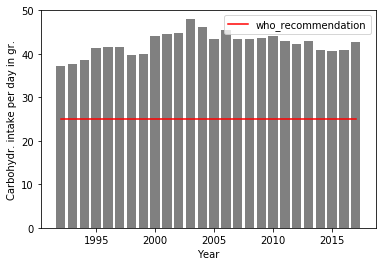

In [37]:
plt.bar(uk_sweets_data_annually.year, uk_sweets_data_annually.sum_of_the_categories, color = "grey")
#plt.plot(uk_sweets_data_annually.year, uk_sweets_data_annually.sum_of_the_categories)
plt.plot(uk_sweets_data_annually.year, uk_sweets_data_annually.who_recommendation, c="red" )
plt.legend()
plt.ylabel("Carbohydr. intake per day in gr.")
plt.xlabel('Year')
plt.ylim(0,50)
plt.show()

In [38]:
stats.ttest_1samp(uk_sweets_data_annually.sum_of_the_categories,25.0)

Ttest_1sampResult(statistic=34.58818349684489, pvalue=1.234712135691676e-22)

The p-value of under 0.001 allows me the reject the null hypothesis and conclude that the sugar intake from only 3 categories exceeds the WHO recommendation.

The test can be expanded with a Monte Carlo simulation, taking different products each day and calculating the intake per day. However, the overall outcome remains alarming as it is now - ice cream + sweets + soft drinks based on our current intake is more than enough to cover our sugar baseline. 

## **4. Marking warnings to additives**

Topic of general interest is what exactly is in our food. In the EU, the famous "E-numbers" - given to food additives were intended to give clarity by providing additional information next to the scary chemistry names. Instead, they lead to much further discussion. Are all E-numbers bad? Which ones of all are bad? How can we find out which ones are? How much of a certain E-number is too much?

Considering the public interest in the topic, the available information online is difficult to work with. The EU has made available search engines and databases on the topic, but downloading a CSV file with the data is not available. One has either have to scrape one-by-one or in one of the EU sites, know SQL to pull a report. Similarly, FAO and WHO have information on each of the additives, but none is available in a ready dataset.

My approach was to collect the information that is clearly understandable and easily available. I used the website of the UK Food agency and Wikipedia's additives page and built a small dataset of 3 columns - additive's name, EU E-number and the warning.

In [39]:
additives_with_warnings = pd.read_csv("additives_with_warnings.csv")

In [40]:
additives_with_warnings.head(5)

,ingredient,eu_nr,information
0,Allura red,E129,‘May have an adverse effect on activity and at...
1,Aspartame,No EU number,‘Contains a source of phenylalanine’
2,Caffeine over 150 mg/l,No EU number,"‘Not suitable for children, pregnant women and..."
3,Carmoisine,E122,‘May have an adverse effect on activity and at...
4,Liquorice,No EU number,‘Contains liquorice’ (you may need extra wordi...


Before proceeding with the mapping, I need to restructure the additives dataframe for easier referencing (I should have thought about this in first place when building the table). I will combine the name and E-Nr columns in one, leaving only two columns - one for the additives name/number and one for the warning. Additionally, I will add the name of the additive in the warning to allow for easier interpretation afterwards.

In [41]:
additives_with_warnings['full_information'] = additives_with_warnings.ingredient+"/"+additives_with_warnings.eu_nr + ": " + additives_with_warnings.information

In [42]:
additives_with_warnings_slice1 = additives_with_warnings[['ingredient', 'full_information']]
additives_with_warnings_slice2 = additives_with_warnings[['eu_nr', 'full_information']]
additives_with_warnings_slice2 = additives_with_warnings_slice2.rename(index=str, columns={"eu_nr": 'ingredient'})
frames = [additives_with_warnings_slice1, additives_with_warnings_slice2]
additives_with_warnings_final = pd.concat(frames, ignore_index = True)

In [43]:
additives_with_warnings_final.head()

,ingredient,full_information
0,Allura red,Allura red/E129: ‘May have an adverse effect o...
1,Aspartame,Aspartame/No EU number: ‘Contains a source of ...
2,Caffeine over 150 mg/l,Caffeine over 150 mg/l/No EU number: ‘Not suit...
3,Carmoisine,Carmoisine/E122: ‘May have an adverse effect o...
4,Liquorice,Liquorice/No EU number: ‘Contains liquorice’ (...


With the Warnings dataset ready, I can now proceed and add the information to the Food Data. I did not find a vectorized way of doing this vlookup-like operation, but using subsetting proved to be at least functioning. 

In [44]:
food_data['warnings'] = np.nan #Creating a column to contain the warnings

In [45]:
for row in range(additives_with_warnings_final.shape[0]):
    food_data.loc[food_data.additives_en.str.contains(additives_with_warnings_final.ingredient[row], case = False) == True, 'warnings'] = additives_with_warnings_final.full_information[row]

In [46]:
food_data.warnings.unique()

array([nan,
       'Sunset yellow/E110: ‘May have an adverse effect on activity and attention in children’',
       'Tartrazine/E102: ‘May have an adverse effect on activity and attention in children’',
       'Allura red/E129: ‘May have an adverse effect on activity and attention in children’',
       'Aspartame/No EU number: ‘Contains a source of phenylalanine’',
       'Potassium bromate/E924: Banned in the EU',
       'Fast Green/E143: Banned in the EU',
       'Carmoisine/E122: ‘May have an adverse effect on activity and attention in children’',
       'Quinoline yellow/E104: ‘May have an adverse effect on activity and attention in children’',
       'Ponceau 4R/E124: ‘May have an adverse effect on activity and attention in children’',
       'Amaranth/E123: Banned in the United States'], dtype=object)

In [47]:
food_data.groupby('warnings').size().sort_values(ascending = False)

warnings
Tartrazine/E102: ‘May have an adverse effect on activity and attention in children’          7488
Allura red/E129: ‘May have an adverse effect on activity and attention in children’          4439
Sunset yellow/E110: ‘May have an adverse effect on activity and attention in children’       2517
Aspartame/No EU number: ‘Contains a source of phenylalanine’                                 1711
Potassium bromate/E924: Banned in the EU                                                      195
Ponceau 4R/E124: ‘May have an adverse effect on activity and attention in children’            36
Quinoline yellow/E104: ‘May have an adverse effect on activity and attention in children’      21
Carmoisine/E122: ‘May have an adverse effect on activity and attention in children’            21
Fast Green/E143: Banned in the EU                                                               3
Amaranth/E123: Banned in the United States                                                      2
dtype: int6

In [48]:
food_data[food_data.warnings.str.contains('Banned')==True].countries.unique()

array(['US', 'Belgique'], dtype=object)

In [50]:
food_data[food_data.warnings.str.contains('Banned')==True].loc[food_data.countries == 'Belgique']

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,warnings
235972,3289251390024,http://world-en.openfoodfacts.org/product/3289...,minouche,1350685161,2012-10-19T22:19:21Z,1365109060,2013-04-04T20:57:40Z,Punch Goyavier Banane,Punch au fruits,70 Cl,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amaranth/E123: Banned in the United States


In [51]:
column_to_chr_counter(food_data[food_data.warnings.str.contains('adverse')==True].categories_tags)

,Count of occurances
en:sugary-snacks,204
en:plant-based-foods-and-beverages,149
en:beverages,147
en:dairies,118
en:plant-based-foods,116
en:cheeses,114
en:confectioneries,109
en:meals,106
en:cereals-and-potatoes,75
en:chocolates,68


The substances banned in the EU are found in food from the US and the other way arround. While it is calming that I found no law-breaking EU behaviour, the recent talks of trade restrictions removal (including such bans) are concerning. 

The majority of the items with potential adverse affects on children are, unfortunately, found in categories of upmost interest for kids - snacks, soft drinks and sweets. Until more strict regulations are in place, it will be up to the parents to understand what they fill their fridges with.

## 4. Conclusion

This short study aimed to first understand what value and what biases are there in the Open Food Data. The dataset is a tremendous sourse of food related information. One needs to have in mind the specifics of the data sources and the data collection methods when choosing what to use the dataset for. 

Additionally, I looked at two popular concerns - How much sugar do we eat and What is in the food today. Much can be done to further expand on both topics. Sugar intakes can be simulated with consequences of day-to-day fluctuations understood better. Additionally, fibres in the food change the way our body treats sugar and should be taken into account. One fact is clear - we eat too much sugar and need to actively work to reduce our intake.

The current food economy cannot work without additives. However, there is still much work to be done explaining the effects of some of them to buyers and consumers. Further areas of research can be exactly how much of a certain additive is in a food item and what happens when its amount adds-up with different food items. For now, just understanding labeling and looking for warnings on it is a benefit in and of itself.


## References

1) https://www.kaggle.com/openfoodfacts/world-food-facts/home <br />
2) http://ec.europa.eu/semantic_webgate/query/dataset=additives# <br />
3) https://www.gov.uk/food-labelling-and-packaging/food-and-drink-warnings <br />
4) G. Singh et all. "Global, Regional, and National Consumption of Sugar-Sweetened Beverages, Fruit Juices, and Milk: A Systematic Assessment of Beverage Intake in 187 Countries", 2015, https://doi.org/10.1371/journal.pone.0124845 <br />
5) https://www.gov.uk/government/statistical-data-sets/family-food-datasets (Source of the second dataset) <br />
6) https://en.wikipedia.org/wiki/List_of_countries_by_body_mass_index <br />
7) https://www.gov.uk/food-labelling-and-packaging/food-and-drink-warnings <br />
8) "Sugar intake for adults and children", World Health Organization, 2015 http://apps.who.int/iris/bitstream/handle/10665/149782/9789241549028_eng.pdf?sequence=1 <br />
9) https://webgate.ec.europa.eu/foods_system/main/?event=display - EU database on additives, potential source for further work <br />
10) https://en.wikipedia.org/wiki/E_number <br />
11) https://www.food.gov.uk/business-guidance/eu-approved-additives-and-e-numbers <br />
